## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [1]:
import os
import tensorflow as tf
import keras
import numpy as np
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # 按照 PCI_BUS_ID 順序從0開始排列 GPU 設備 
os.environ["CUDA_VISIBLE_DEVICES"]="1,0" #設置當前使用的 GPU 設備為1,0號兩個設備,名稱依次為'/gpu:0'、'/gpu:1'。表示優先使用1號設備,然後使用0號設備

Using TensorFlow backend.


## Data Pre-processing

In [2]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Do one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


## Parameter

In [3]:
# Set the parameter
batch_size = 64
epochs = 20
num_classes = 10
lr = 1e-3

## Model

In [4]:
# Import ResNet50 as basis model 
model_b = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(x_train.shape[1],x_train.shape[2],3))

# Abandon the FC-layer on the top of ResNet50
x = model_b.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation = 'softmax', name = 'output_layer')(x)
model = Model(inputs=model_b.input, outputs=output_layer)
model.summary()

# Compile
model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Vincent\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

## Augmentation

In [5]:
datagen = ImageDataGenerator(    
    featurewise_center=False,    
    samplewise_center=False,    
    featurewise_std_normalization=False,    
    samplewise_std_normalization=False,    
    zca_whitening=False,    
    zca_epsilon=1e-06,    
    rotation_range=0,    
    width_shift_range=0.1,    
    height_shift_range=0.1,    
    shear_range=0.,    
    zoom_range=0.,    
    channel_shift_range=0.,    
    fill_mode='nearest',    
    cval=0.,    
    horizontal_flip=True,    
    vertical_flip=False,    
    rescale=None,    
    preprocessing_function=None,    
    data_format=None,    
    validation_split=0.0)

datagen.fit(x_train)

## Fit the data

In [6]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=int(len(x_train)/batch_size),
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test, y_test))

scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Epoch 1/20
781/781 [==============================] - 1784s 2s/step - loss: 3.0283 - accuracy: 0.1621 - val_loss: 14.5025 - val_accuracy: 0.1365
Epoch 2/20
781/781 [==============================] - 1723s 2s/step - loss: 2.0599 - accuracy: 0.2925 - val_loss: 2.2360 - val_accuracy: 0.4459
Epoch 3/20
781/781 [==============================] - 1735s 2s/step - loss: 1.7041 - accuracy: 0.4215 - val_loss: 2.3004 - val_accuracy: 0.5398
Epoch 4/20
781/781 [==============================] - 1775s 2s/step - loss: 1.4442 - accuracy: 0.5100 - val_loss: 1.5258 - val_accuracy: 0.6010
Epoch 5/20
781/781 [==============================] - 1685s 2s/step - loss: 1.2571 - accuracy: 0.5717 - val_loss: 1.2620 - val_accuracy: 0.6402
Epoch 6/20
781/781 [==============================] - 1678s 2s/step - loss: 1.1279 - accuracy: 0.6167 - val_loss: 1.0502 - val_accuracy: 0.6807
Epoch 7/20
781/781 [==============================] - 1676s 2s/step - loss: 1.0259 - accuracy: 0.6513 - val_loss: 0.8781 - val_accuracy

## Plot

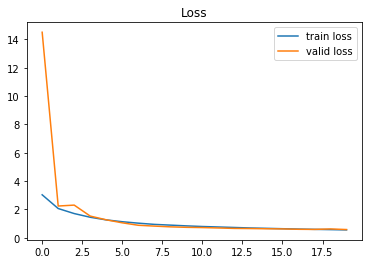

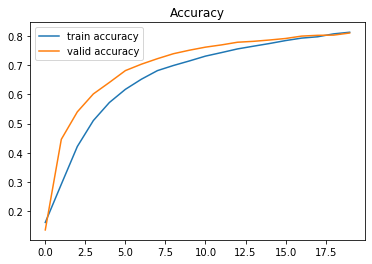

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()